## Final Project Submission

Please fill out:
* Student name: **Andrew Bennett**
* Student pace: **self paced** / part time / full time
* Scheduled project review date/time: 
* Instructor name: **Morgan Jones**
* Blog post URL:


# BREAKING DOWN THE BLOCK BUSTERS
## Analysis of Top Grossing Movies in Theaters of Last 20 years
### Author: Andrew Bennett

The business of film is to make dreams into reality, and allow audiences to escape for a few hours.

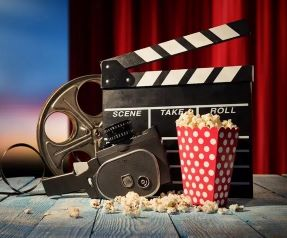

# But... how do we begin in the Film Business?

There are numerous decisions to make to begin the process of making movies. A film studio has to capture the imagination of an audience but also make money. Why? So they can do it again the next day! To aid Microsoft in this voyage, this analysis will examine various factors that go into making a movie and determine if there are any trends as they relate to box office ticket sales. We'll look at the following:

* genre
* budget
* directors

These factors represent some of the simplest, more foundational decisions. Genre determines which scripts and creative teams you'll need. The budget is the money you'll need upfront to greenlight a project. And the director is the creative lead who will shepard the day-to-day movie-making and ultimately deliver the project to you and your audience. 

So... where do we start?

## with DATA


To solve this problem we used two well-known industry databases. The IMDB movie database (https://www.imdb.com/) is one of the most complete, publically box office available databases. It's a well known industry staple and incredibly robust. However, We also need budget information, and that's what we'll get from The Numbers (https://www.the-numbers.com/) which reports daily and weekly box office sales for movies currently in release. From there, we examine the movie titles, genres, production budgets, directors and their respective  gross box office receipts. The goal is to find which of these "input" trends have an effect, if any, on box office number "output".


So... shall we get started?

First, let's import some of our standard packages. 

### Import standard packages

In [48]:
#importing standard libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Preparation

First we're going to poke around the IMDB database. Luckily this database can be accessed using `sqlite3`. I'm going to pull the table names just to get a flavor of the data we have.

In [49]:
#import sqlite3
import sqlite3

#create a connection and execute query for table names
conn = sqlite3.connect("zippedData/im.db")
df = pd.read_sql("""SELECT name 
                    FROM sqlite_master 
                    WHERE type = 'table'
;""", conn)
df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Good... These are the tables that were shown in the diagram provided in the Project Description, so I think it's safe to use the keys listed in said diagram.  

Let's look for potential row names that will help with either, budget, genres, and director. `movie_basics` table looks promising, as does `directors` and `persons`. There's no budget data here (we'll address that later), but let's pull the relevant genre and director info that we do care about. I'm also going to pull `start_year` and `primary_title`.

I will do this by doing a sqlite3 query and joining some tables in the process. 

In [50]:
#query relevant data
df1 = pd.read_sql("""SELECT DISTINCT movie_id, primary_title, start_year, genres, person_id, primary_name 
                     FROM movie_basics
                     JOIN directors
                         USING(movie_id)
                     JOIN persons
                         USING(person_id)
;""", conn)

#reset index to primary_title
df1.set_index('primary_title', inplace = True)
df1

,movie_id,start_year,genres,person_id,primary_name
primary_title,,,,,
Sunghursh,tt0063540,2013,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail
One Day Before the Rainy Season,tt0066787,2019,"Biography,Drama",nm0002411,Mani Kaul
The Other Side of the Wind,tt0069049,2018,Drama,nm0000080,Orson Welles
Sabse Bada Sukh,tt0069204,2018,"Comedy,Drama",nm0611531,Hrishikesh Mukherjee
The Wandering Soap Opera,tt0100275,2017,"Comedy,Drama,Fantasy",nm0749914,Raoul Ruiz
...,...,...,...,...,...
Rodolpho Teóphilo - O Legado de um Pioneiro,tt9916622,2015,Documentary,nm9272491,Ana Célia de Oliveira
Dankyavar Danka,tt9916706,2013,Comedy,nm7764440,Kanchan Nayak
6 Gunn,tt9916730,2017,None,nm10538612,Kiran Gawade


Good news! We've got some good looking info here. Lot's of entries. And it looks like some of the movies have two entries, based on a one-to-many join with the directors table. In other words, some movies have multiple directors, and that creates multiple entries for one movie, which isn't good. So let's do some... 


### Data Manipulation
#### - with Directors

We need to remove duplicated entries from the list due to multiple directors. We can see from above that "Chico Albuquerque - Revelações" was duplicated because of credits for both Vinicius Augusto Bozzo and Angela Gurgel. This is NO BUENO.

I'm going to see how many occurrences there are with two directors vs one director. While I'm at it I'll also check for more than two. 

To do this - I'm going to run a very shitty, inefficient loop and count the maximum number of director credits for any one movie, the total number of single director movies, double director movies, and 3 or more director movies. 

In [51]:
#setting up variables 
index=0;
ctr=0;
numdirectors=0;
directors=[]
one_director=0;
two_directors=0;
many_directors=0;

#for loop that iterates through each movie with an opening conditional to stop before we get to the last entry.
for movie in df1['movie_id']:
    if index < (len(df1['movie_id'])-1):
        #If the movie is the equal to the next element in the list, we increase the ctr.
        if (df1.iloc[index,0] == df1.iloc[index+1,0]):
            ctr+=1
        #If the ctr is greater than the largest number of directors on a movie (numdirectors), then numdirectors = ctr.
            if ctr>numdirectors:
                numdirectors=ctr
                directors.append(df1.iloc[index,0])
        #else, the movie is not equal to the next element, that update the count of onedirector, twodirector, and many_directors
        else:
            if ctr==0:
                 one_director+=1
            if ctr==1:
                 two_directors+=1
            if ctr>=2:
                 many_directors+=1
            ctr=0
        index+=1
        
print("The most directors on a single move are ", numdirectors)
print("Total entries: ", index)
print("My counter check: ",ctr)
print(one_director, " movie entries have only one director")
print(two_directors, " movie entries have only one director")
print(many_directors," entries have three or more directors")

The most directors on a single move are  82
Total entries:  163532
My counter check:  1
124689  movie entries have only one director
13226  movie entries have only one director
2500  entries have three or more directors


What? 82 directors on a movie? They're handing out credits like condoms these days!  

We also see that approximately 124,689 movie entries have one director, and 13,226 have two. So we can add a second director column but that's IT. There are 2500 entries with 3 or more, or less than 3%. We can truncate these entries and only inlcude the first two names on the list. Let's go ahead and add another column for direct_2 and fill it in with the second director listed.

Unfortunately, I'm going to do another, kind of shitty loop, here. I apologize in advance.

In [52]:
#setting up variables 

df1['director_2']=None;
index=0;
ctr=0;
numdirectors=0;
directors=[]
many_director_ctr=0;

#for loop that iterates through each movie with an opening conditional to stop before we get to the last entry.
for movie in df1['movie_id']:
    if index < (len(df1['movie_id'])-1):
        
#If the movie is the equal to the next element in the list, we increase the ctr. If the ctr == 1, meaning it's the second director, then we add that name to the new director_2 column
        if (df1.iloc[index,0] == df1.iloc[index+1,0]):
            ctr+=1
            if ctr==1:
                df1.iloc[index,5] = df1.iloc[index+1,4]
        else:
            ctr=0
        index+=1
df1

,movie_id,start_year,genres,person_id,primary_name,director_2
primary_title,,,,,,
Sunghursh,tt0063540,2013,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,None
One Day Before the Rainy Season,tt0066787,2019,"Biography,Drama",nm0002411,Mani Kaul,None
The Other Side of the Wind,tt0069049,2018,Drama,nm0000080,Orson Welles,None
Sabse Bada Sukh,tt0069204,2018,"Comedy,Drama",nm0611531,Hrishikesh Mukherjee,None
The Wandering Soap Opera,tt0100275,2017,"Comedy,Drama,Fantasy",nm0749914,Raoul Ruiz,Valeria Sarmiento
...,...,...,...,...,...,...
Rodolpho Teóphilo - O Legado de um Pioneiro,tt9916622,2015,Documentary,nm9272491,Ana Célia de Oliveira,None
Dankyavar Danka,tt9916706,2013,Comedy,nm7764440,Kanchan Nayak,None
6 Gunn,tt9916730,2017,None,nm10538612,Kiran Gawade,None


Great. So we added a second director column and populated it. We will now get rid of the duplicates. 

In [53]:
df1 = df1.drop_duplicates(subset = 'movie_id',keep = 'first')
df1

,movie_id,start_year,genres,person_id,primary_name,director_2
primary_title,,,,,,
Sunghursh,tt0063540,2013,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,None
One Day Before the Rainy Season,tt0066787,2019,"Biography,Drama",nm0002411,Mani Kaul,None
The Other Side of the Wind,tt0069049,2018,Drama,nm0000080,Orson Welles,None
Sabse Bada Sukh,tt0069204,2018,"Comedy,Drama",nm0611531,Hrishikesh Mukherjee,None
The Wandering Soap Opera,tt0100275,2017,"Comedy,Drama,Fantasy",nm0749914,Raoul Ruiz,Valeria Sarmiento
...,...,...,...,...,...,...
Kuambil Lagi Hatiku,tt9916538,2019,Drama,nm8185151,Azhar Kinoi Lubis,None
Rodolpho Teóphilo - O Legado de um Pioneiro,tt9916622,2015,Documentary,nm9272490,Angela Gurgel,Ana Célia de Oliveira
Dankyavar Danka,tt9916706,2013,Comedy,nm7764440,Kanchan Nayak,None


Great, we really simplified this director issue. We have the director information, and the genre. Okay. let's see if we can find some budget information and then we'll do another round of data cleaning.

## Budget Data Import

As we mentioned above, a critical component of this is to have the financial information. 

Luckily we have some of that information right here from The Numbers website. So let's go ahead and import that.

In [54]:
#import csv file and let's make the index the movie

df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df.set_index('movie', inplace =True)
df


,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009","$425,000,000","$760,507,625","$2,776,345,279"
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011","$410,600,000","$241,063,875","$1,045,663,875"
Dark Phoenix,3,"Jun 7, 2019","$350,000,000","$42,762,350","$149,762,350"
Avengers: Age of Ultron,4,"May 1, 2015","$330,600,000","$459,005,868","$1,403,013,963"
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017","$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
Red 11,78,"Dec 31, 2018","$7,000",$0,$0
Following,79,"Apr 2, 1999","$6,000","$48,482","$240,495"
Return to the Land of Wonders,80,"Jul 13, 2005","$5,000","$1,338","$1,338"


Nice! This table was imported smoothly. So let's join these two tables together and get our MEGA table! I'll do an inner join because I only care about the movies that I can sync all three (genre, directors, and budget/financial info).

In [55]:
genre_and_budget = df.join(df1, how = "inner")
genre_and_budget

,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,primary_name,director_2
#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,Tara Subkoff,None
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",tt1179933,2016,"Drama,Horror,Mystery",nm0870469,Dan Trachtenberg,None
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",tt3453052,2015,Drama,nm0385725,Timothy Hines,None
12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",tt3517850,2017,"Action,Drama,Romance",nm1217972,Gabriel Soriano,None
12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",tt1413492,2018,"Action,Drama,History",nm3350420,Nicolai Fuglsig,None
...,...,...,...,...,...,...,...,...,...,...,...
Zoom,26,"Aug 11, 2006","$35,000,000","$11,989,328","$12,506,188",tt6117454,2016,"Crime,Thriller",nm2750788,Anish Varma,None
Zoom,26,"Aug 11, 2006","$35,000,000","$11,989,328","$12,506,188",tt6667868,2016,Horror,nm8859604,Sameera Wackwella,None
Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616",tt2948356,2016,"Adventure,Animation,Comedy",nm0397174,Byron Howard,Rich Moore
Zulu,82,"Dec 31, 2013","$16,000,000",$0,"$1,844,228",tt2249221,2013,"Crime,Drama,Thriller",nm1362432,Jérôme Salle,None


Okay. Now we have our MEGA table. Let's Clean Up This Data. Already we see some repititions.

## Data Cleaning

First, let's reset the index and remove the duplicates.


In [56]:
#remove duplicates
genre_and_budget = genre_and_budget.reset_index()

#remove duplicates based on movie_id
genre_and_budget = genre_and_budget.drop_duplicates(subset = 'movie_id',keep = 'first')

#remove duplicates based on the name and release date
genre_and_budget = genre_and_budget.drop_duplicates(subset = ['index', 'release_date'], keep = 'first')
genre_and_budget.head(20)

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,primary_name,director_2
0,#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,Tara Subkoff,None
1,10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",tt1179933,2016,"Drama,Horror,Mystery",nm0870469,Dan Trachtenberg,None
2,10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",tt3453052,2015,Drama,nm0385725,Timothy Hines,None
3,12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",tt3517850,2017,"Action,Drama,Romance",nm1217972,Gabriel Soriano,None
4,12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",tt1413492,2018,"Action,Drama,History",nm3350420,Nicolai Fuglsig,None
5,12 Years a Slave,18,"Oct 18, 2013","$20,000,000","$56,671,993","$181,025,343",tt2024544,2013,"Biography,Drama,History",nm2588606,Steve McQueen,None
6,127 Hours,6,"Nov 5, 2010","$18,000,000","$18,335,230","$60,217,171",tt1542344,2010,"Adventure,Biography,Drama",nm0000965,Danny Boyle,None
7,13 Sins,51,"Apr 18, 2014","$4,000,000","$9,134","$47,552",tt2059171,2014,"Horror,Thriller",nm0821844,Daniel Stamm,None
8,1982,23,"Mar 1, 2016","$1,000,000",$0,$0,tt2388621,2013,Drama,nm2179966,Tommy Oliver,None
10,2 Guns,39,"Aug 2, 2013","$61,000,000","$75,612,460","$132,493,015",tt1272878,2013,"Action,Comedy,Crime",nm0466349,Baltasar Kormákur,None


## Convert Financial Info to Integers

Good, now let's convert the box office sales to integers so that we can manipulate them. I'm going to create a function called `conversion` and map each to each column. The `conversion` function will strip away "," and "$" and convert the string to and integer.

In [57]:
#create function to strip '$' and ','
def conversion(value):
    value=value.strip('$')
    value=value.replace(",","")
    return int(value)

#map each column with financials to the function
genre_and_budget['production_budget']=genre_and_budget['production_budget'].map(conversion)
genre_and_budget['domestic_gross']=genre_and_budget['domestic_gross'].map(conversion)
genre_and_budget['worldwide_gross']=genre_and_budget['worldwide_gross'].map(conversion)

genre_and_budget

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,primary_name,director_2
0,#Horror,16,"Nov 20, 2015",1500000,0,0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,Tara Subkoff,None
1,10 Cloverfield Lane,54,"Mar 11, 2016",5000000,72082999,108286422,tt1179933,2016,"Drama,Horror,Mystery",nm0870469,Dan Trachtenberg,None
2,10 Days in a Madhouse,48,"Nov 11, 2015",12000000,14616,14616,tt3453052,2015,Drama,nm0385725,Timothy Hines,None
3,12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,2017,"Action,Drama,Romance",nm1217972,Gabriel Soriano,None
4,12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",nm3350420,Nicolai Fuglsig,None
...,...,...,...,...,...,...,...,...,...,...,...,...
3719,Zoolander 2,64,"Feb 12, 2016",50000000,28848693,55348693,tt1608290,2016,Comedy,nm0001774,Ben Stiller,None
3720,Zoom,26,"Aug 11, 2006",35000000,11989328,12506188,tt3763866,2015,"Animation,Comedy,Drama",nm2222834,Pedro Morelli,None
3724,Zootopia,57,"Mar 4, 2016",150000000,341268248,1019429616,tt2948356,2016,"Adventure,Animation,Comedy",nm0397174,Byron Howard,Rich Moore
3725,Zulu,82,"Dec 31, 2013",16000000,0,1844228,tt2249221,2013,"Crime,Drama,Thriller",nm1362432,Jérôme Salle,None


## Convert Genre Info to String

And now, for genre.
It appears that the genre category doesn't have one entry. And, it's not a string... Okay. Let's first convert to a string. I'm going to do something similar as I did above. I'll create a function to convert genres to a string.

In [58]:
#create function to convert an unknown object to a string
def convert_string(value):
    new_value = str(value)
    return new_value

#map each financial series to the function
genre_and_budget['genres'] = genre_and_budget['genres'].map(convert_string)
genre_and_budget

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,primary_name,director_2
0,#Horror,16,"Nov 20, 2015",1500000,0,0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,Tara Subkoff,None
1,10 Cloverfield Lane,54,"Mar 11, 2016",5000000,72082999,108286422,tt1179933,2016,"Drama,Horror,Mystery",nm0870469,Dan Trachtenberg,None
2,10 Days in a Madhouse,48,"Nov 11, 2015",12000000,14616,14616,tt3453052,2015,Drama,nm0385725,Timothy Hines,None
3,12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,2017,"Action,Drama,Romance",nm1217972,Gabriel Soriano,None
4,12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",nm3350420,Nicolai Fuglsig,None
...,...,...,...,...,...,...,...,...,...,...,...,...
3719,Zoolander 2,64,"Feb 12, 2016",50000000,28848693,55348693,tt1608290,2016,Comedy,nm0001774,Ben Stiller,None
3720,Zoom,26,"Aug 11, 2006",35000000,11989328,12506188,tt3763866,2015,"Animation,Comedy,Drama",nm2222834,Pedro Morelli,None
3724,Zootopia,57,"Mar 4, 2016",150000000,341268248,1019429616,tt2948356,2016,"Adventure,Animation,Comedy",nm0397174,Byron Howard,Rich Moore
3725,Zulu,82,"Dec 31, 2013",16000000,0,1844228,tt2249221,2013,"Crime,Drama,Thriller",nm1362432,Jérôme Salle,None


### Convert Genre Date to a Date

Let's see the oldest and newest movie to be released. First, we'll convert the date to datatime.

In [92]:
#convert date
genre_and_budget['release_date'] = pd.to_datetime(genre_and_budget['release_date'], infer_datetime_format=True)

#sort by date
genre_and_budget.sort_values('release_date').head(70)

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
3645,Wings,85,1927-08-12,2000000,0,0,tt2284790,2012,"Adventure,Animation,Comedy",nm5174437,...,0,0,0,0,0,0,0,0,0,0
1756,Mata Hari,24,1931-12-26,558000,900000,900000,tt8788464,2016,Biography,nm10022592,...,0,0,0,0,0,0,0,0,0,0
2430,Snow White and the Seven Dwarfs,18,1937-12-21,1488000,184925486,184925486,tt7821084,2017,"Animation,Family",nm8856734,...,0,0,0,0,0,0,0,0,0,0
2156,Rebecca,47,1940-03-21,1288000,6000000,6002370,tt10430534,2018,Horror,nm10738969,...,1,0,0,0,0,0,0,0,0,0
932,Fantasia,69,1940-11-13,2280000,83320000,83320000,tt3591950,2014,Drama,nm0910852,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,Stand by Me,68,1986-08-08,8000000,52287414,52287414,tt8383596,2018,Drama,nm9822619,...,0,0,0,0,0,0,0,0,0,0
2077,Playing for Keeps,49,1986-10-03,35000000,2000000,2000000,tt1540128,2012,"Comedy,Romance,Sport",nm0610831,...,0,0,0,0,1,0,1,0,0,0
2879,The Golden Child,47,1986-12-12,12000000,79817937,79817937,tt3506476,2012,Drama,nm1739245,...,0,0,0,0,0,0,0,0,0,0
2229,River's Edge,4,1987-05-08,1900000,4600000,4600000,tt7476946,2018,Crime,nm0950834,...,0,0,0,0,0,0,0,0,0,0


## VOILA - We have our data in a good place! Now let's clean our table up a little more.

We're going to add some additional financial info as well as eliminate some older movies. Movies before 2000 may not help us much.


Let's go ahead and slice the data and keep movies that are 2000 and later.

In [97]:
#slice movies > than 2000
genre_and_budget = genre_and_budget.loc[genre_and_budget['release_date'] > '2000-01-01']
genre_and_budget.sort_values('release_date')

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
3281,The Terrorist,48,2000-01-14,25000,195043,195043,tt9248762,2018,Thriller,nm10244758,...,0,0,0,0,0,0,0,1,0,0
2551,Supernova,41,2000-01-14,60000000,14218868,14816494,tt10378772,2020,Drama,nm2718708,...,0,0,0,0,0,0,0,0,0,0
1148,Gun Shy,86,2000-02-04,10000000,1638202,1638202,tt3910736,2017,"Action,Adventure,Comedy",nm0922346,...,0,0,0,0,0,0,0,0,0,0
2427,Snow Day,51,2000-02-11,13000000,60008303,62452927,tt4163946,2014,"Action,Documentary,Drama",nm1490791,...,0,0,0,0,0,0,0,0,0,0
3676,Wonder Boys,13,2000-02-23,35000000,19389454,33422485,tt9095294,2018,"Crime,Thriller",nm10176250,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,The Rhythm Section,8,2019-11-22,50000000,0,0,tt7134096,2019,"Action,Mystery,Thriller",nm1543747,...,0,0,1,0,0,0,0,1,0,0
2257,Rogue City,13,2019-12-31,13000000,0,0,tt10329540,2020,None,nm0545356,...,0,0,0,0,0,0,0,0,0,0
873,Eli,16,2019-12-31,11000000,0,0,tt4786638,2015,Comedy,nm6405547,...,0,0,0,0,0,0,0,0,0,0
2154,Reagan,30,2019-12-31,25000000,0,0,tt1822382,2011,"Biography,Documentary",nm0418659,...,0,0,0,0,0,0,0,0,0,0


## Financial Data Manipulation

It seems like we have the numbers converted and the strings converted to strings. Let's add a few more columns to show ROI and Gross Margin. I've defined Gross Margin as the difference between how much money was grossed worldwide and how much was spent in production, or production budet. 

We'll define ROI (Return on Investment) as just Worldwide Budget divided by Production Budget. So, an ROI of 1 means a movie "broke even" or made it's money back.

We should take a second to note that we have not factored in marketing or distribution costs into either of these numbers. This data is not as readily accessible on this scale.

In [98]:
#create new columns as mathematical operations of existing columns
genre_and_budget['ROI'] = round (genre_and_budget['worldwide_gross'] / genre_and_budget['production_budget'],2)
genre_and_budget['Gross_Margin'] = round (genre_and_budget['worldwide_gross'] - genre_and_budget['production_budget'],2)
genre_and_budget

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,#Horror,16,2015-11-20,1500000,0,0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,...,1,0,0,0,0,0,0,0,0,0
1,10 Cloverfield Lane,54,2016-03-11,5000000,72082999,108286422,tt1179933,2016,"Drama,Horror,Mystery",nm0870469,...,1,0,1,0,0,0,0,0,0,0
2,10 Days in a Madhouse,48,2015-11-11,12000000,14616,14616,tt3453052,2015,Drama,nm0385725,...,0,0,0,0,0,0,0,0,0,0
3,12 Rounds,37,2009-03-27,20000000,12234694,17306648,tt3517850,2017,"Action,Drama,Romance",nm1217972,...,0,0,0,0,1,0,0,0,0,0
4,12 Strong,64,2018-01-19,35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",nm3350420,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,Zoolander 2,64,2016-02-12,50000000,28848693,55348693,tt1608290,2016,Comedy,nm0001774,...,0,0,0,0,0,0,0,0,0,0
3720,Zoom,26,2006-08-11,35000000,11989328,12506188,tt3763866,2015,"Animation,Comedy,Drama",nm2222834,...,0,0,0,0,0,0,0,0,0,0
3724,Zootopia,57,2016-03-04,150000000,341268248,1019429616,tt2948356,2016,"Adventure,Animation,Comedy",nm0397174,...,0,0,0,0,0,0,0,0,0,0
3725,Zulu,82,2013-12-31,16000000,0,1844228,tt2249221,2013,"Crime,Drama,Thriller",nm1362432,...,0,0,0,0,0,0,0,1,0,0


Yes!!!! We have mega table. We're very close to  analyzing the data, we just need to separate the genre information so we can individualize the categories.

## Question 1 - Which genre of movies do the best at the box office?

Okay, to answer this question, we need to separate all of the genres into their own columns, so each movie entry will have every genre category. What do I mean? Let's say a moive is a mix of `Action`, `Comedy`, and `Adventure`. That entry then would have a 1 in the `Action` column, a 1 in the `Comedy` column, and a 1 in the `Adventure` column. The other columns would have a 0, meaning that genre is not represented in this movie.

Sounds good right! Let's do some genre cleaning.

### GENRE TITLE CLEANING

First, we have to determine how many unique genre categories exist. And then we can create separate columns for each of the genres. This way the genres will be easily categorized later.

In [99]:
#using list comprehension, make a list of every genre word using a lambda function and split.
genre_list = [item for genres in list(genre_and_budget['genres'].map(lambda x: x.split(","))) for item in genres]

# then make the list unique.
list(set(genre_list))


['Adventure',
 'Animation',
 'Sci-Fi',
 'History',
 'Music',
 'Romance',
 'Thriller',
 'Musical',
 'Horror',
 'Mystery',
 'War',
 'Sport',
 'Documentary',
 'Family',
 'None',
 'Drama',
 'Biography',
 'Crime',
 'Action',
 'Comedy',
 'Western',
 'Fantasy']

Great! although carefully looking at the list we see a category `None` as well as two similar categories, `Music` and `Musical`. Let's go ahead and clean those up.

In [100]:
#create a list from the set of 'genre_list'
genre_list = list(set(genre_list))
genre_list.remove('Musical')
genre_list.remove('None')
genre_list

['Adventure',
 'Animation',
 'Sci-Fi',
 'History',
 'Music',
 'Romance',
 'Thriller',
 'Horror',
 'Mystery',
 'War',
 'Sport',
 'Documentary',
 'Family',
 'Drama',
 'Biography',
 'Crime',
 'Action',
 'Comedy',
 'Western',
 'Fantasy']

In [101]:
genre_list.sort()
genre_list

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

Now that looks good! We're ready to add the genre categories as column names with a simple 0,1 to indicate whether that genre category is present in our original genre category.

In [102]:
#write for loop to iterate through each genre in the list we just created
for genre in genre_list:

#for each genre, create a new column with that name and create lambda function to assign 0s and 1s
    genre_and_budget[genre]=genre_and_budget['genres'].map(lambda x: 1 if genre in x else 0)
                                                           
genre_and_budget

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,movie_id,start_year,genres,person_id,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,#Horror,16,2015-11-20,1500000,0,0,tt3526286,2015,"Crime,Drama,Horror",nm0836964,...,1,0,0,0,0,0,0,0,0,0
1,10 Cloverfield Lane,54,2016-03-11,5000000,72082999,108286422,tt1179933,2016,"Drama,Horror,Mystery",nm0870469,...,1,0,1,0,0,0,0,0,0,0
2,10 Days in a Madhouse,48,2015-11-11,12000000,14616,14616,tt3453052,2015,Drama,nm0385725,...,0,0,0,0,0,0,0,0,0,0
3,12 Rounds,37,2009-03-27,20000000,12234694,17306648,tt3517850,2017,"Action,Drama,Romance",nm1217972,...,0,0,0,0,1,0,0,0,0,0
4,12 Strong,64,2018-01-19,35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",nm3350420,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,Zoolander 2,64,2016-02-12,50000000,28848693,55348693,tt1608290,2016,Comedy,nm0001774,...,0,0,0,0,0,0,0,0,0,0
3720,Zoom,26,2006-08-11,35000000,11989328,12506188,tt3763866,2015,"Animation,Comedy,Drama",nm2222834,...,0,0,0,0,0,0,0,0,0,0
3724,Zootopia,57,2016-03-04,150000000,341268248,1019429616,tt2948356,2016,"Adventure,Animation,Comedy",nm0397174,...,0,0,0,0,0,0,0,0,0,0
3725,Zulu,82,2013-12-31,16000000,0,1844228,tt2249221,2013,"Crime,Drama,Thriller",nm1362432,...,0,0,0,0,0,0,0,1,0,0


### Data Analysis

Okay, let's start manipulating data and looking to answer some questions. First, how about `Gross_Margin`. Let's create a table with just `Gross_Margin` and the genre categories

In [103]:
#slice table to create only columns we need
gross_margin = genre_and_budget.loc[:,'Gross_Margin':'Western']

#sort columns in ascending order
gross_margin = gross_margin.sort_values('Gross_Margin', ascending = False)
gross_margin

,Gross_Margin,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
258,2351345279,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
260,1748134200,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1519,1433854864,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1057,1328722794,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2634,1292935897,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,-82000000,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
431,-90000000,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1775,-106900000,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1750,-110450242,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Let's just jump right to it. Which genre if any correlates most strongly with high margins.

Let's start with genre and box office receipts

In [104]:
#create a table correlating all of the variables.
positivecorr = gross_margin.corr().drop('Gross_Margin')

#Now, just show the correlations associate with 'Gross_Margin' in ascending order
question_1a_corr = positivecorr['Gross_Margin'].sort_values(ascending = True)
question_1a_corr


Drama         -0.210502
Crime         -0.077882
Romance       -0.069531
Documentary   -0.068286
Horror        -0.061838
Biography     -0.047755
History       -0.039188
Mystery       -0.037551
Thriller      -0.036598
War           -0.033543
Sport         -0.023850
Music         -0.021382
Western       -0.018811
Comedy         0.008325
Family         0.024850
Fantasy        0.081739
Sci-Fi         0.209867
Action         0.216303
Animation      0.223826
Adventure      0.386086
News                NaN
Name: Gross_Margin, dtype: float64

This is interesting, there appears to be a correlation trend here. With the "adventure" genre showing the strongest correlation. Let's look at this graphed below.


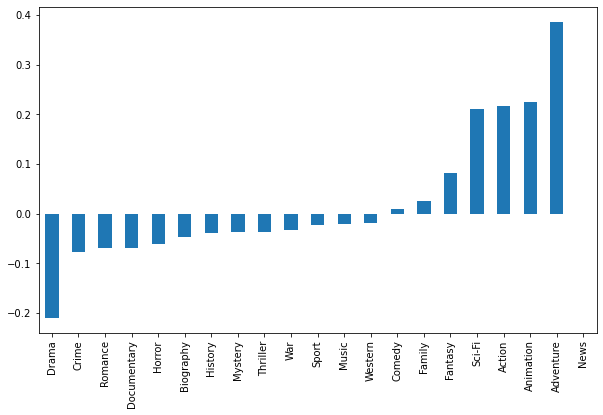

In [105]:
#plot a vertical bar graph
plt.figure(figsize=(10,6))
question_1a_corr.plot.bar()
plt.show()

This graphs shows Adventure movies tend to have the largest profit margins. But it could be because Adventure movies are given such large budgets. While there is a correlation, it's considered weak.

Let's look at the median Gross_Margin values are for each of these genres to get a sense of maybe the "typical movie". We look at median instead of mean because it's less influenced by outliers (meaning super hits and super flops).

In [106]:
#slice a table to get Gross_Margin and all of the genres
question_1a_me = genre_and_budget.loc[:,'Gross_Margin':'Western']

#replace the 1s in the list with the actual Gross_Margin values. 
for genre in genre_list:
    question_1a_me[genre] = question_1a_me[genre] * question_1a_me['Gross_Margin']

#replace the 0s with Nan.
question_1a_me.replace(0, np.nan, inplace = True)

#now create find the median values by each genre
question_1a_me = question_1a_me.drop('Gross_Margin', axis=1)
question_1a_m = question_1a_me.median().sort_values()
question_1a_m

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Western         -2141346.5
War             -1973745.0
Sport             -37395.0
Documentary       255538.0
History           721474.5
Drama            3239723.0
Horror           3327198.0
Crime            4106975.0
Music            4629950.5
Thriller         5139730.0
Romance          7955193.0
Biography        9629774.0
Mystery         14610760.0
Comedy          18831384.0
Family          22938391.0
Fantasy         25474658.0
Sci-Fi          37079671.0
Action          41647574.0
Adventure      110859554.0
Animation      155707267.0
News                   NaN
dtype: float64

Wow, we've seen some trends here. Let's see how this looks visually.


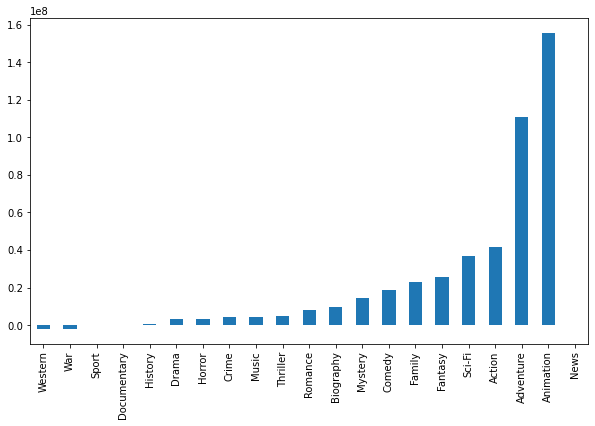

In [107]:
#plot a vertical bar graph
plt.figure(figsize=(10,6))
question_1a_m.plot.bar()
plt.show()

So we see that both Adventure and Animation have the highest median values for Worldwide Gross Margin, but again, we don't factor in ROI here. what about return on investment. 

Let's look at ROI.

In [108]:
#Let's create a table with just ROI and the genres we need.
gross_ROI = genre_and_budget.drop('Gross_Margin', axis = 1)
gross_ROI = gross_ROI.loc[:,'ROI':'Western']

#Let's sort that table by ROI.
gross_ROI = gross_ROI.sort_values('ROI', ascending = False)
gross_ROI

,ROI,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Horror,Music,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
2826,416.56,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2758,101.76,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1430,66.58,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3501,64.36,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2014,59.17,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,0.00,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2822,0.00,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
822,0.00,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
827,0.00,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Okay, now let's see if there's any correlation between genre and ROIs.

In [109]:
#let's find the correlation between different genres and the median ROI
positivecorr = gross_ROI.corr().drop('ROI')
question_1b_corr = positivecorr['ROI']
question_1b_corr

Action        -0.032856
Adventure     -0.011977
Animation      0.005306
Biography     -0.005761
Comedy        -0.012668
Crime         -0.047778
Documentary   -0.023879
Drama         -0.042426
Family        -0.019821
Fantasy       -0.011309
History       -0.019144
Horror         0.141594
Music          0.000690
Mystery        0.139505
News                NaN
Romance        0.008940
Sci-Fi        -0.003994
Sport         -0.005192
Thriller       0.075420
War           -0.018381
Western       -0.013374
Name: ROI, dtype: float64

Interesting, let's look at this visually.

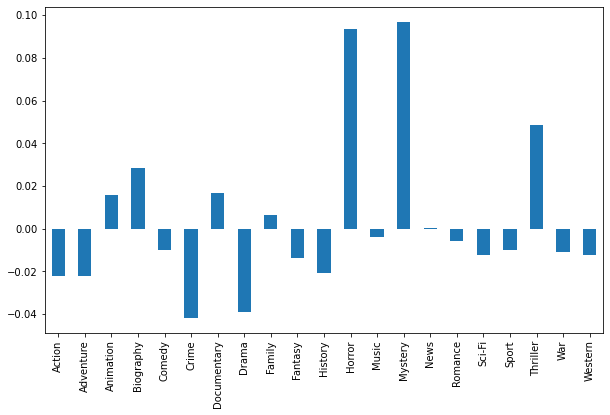

In [73]:
#plot a vertical bar graph
plt.figure(figsize=(10,6))
question_1b_corr.plot.bar()
plt.show()

So we see some trends here. While Mystery and Horror do have the highest correlation, no genre seems to have a STRONG correlation. Generally, any correlation below 0.25 is considered weak.

BASED on the visual above, there's no strong correlation between genre and ROI... This may be why Hollywood makes different kind of movies.


### Visualization 1 - Vertical Bar Graph of Genre Correlation with ROI.

### Recommendation 1 - Focus on a broad variety of genres. No single genre is a strong indicator of ROI success.

Now let's look at the median ROI from each genre.

In [110]:
#slice a table of only ROI and genres
question_1b_me = genre_and_budget.drop('Gross_Margin', axis = 1)
question_1b_me = question_1b_me.loc[:,'ROI':'Western']

#replace the 1s in the list with the ROIs. We'll do this by mathematical operation for each genre in genre_list 
for genre in genre_list:
    question_1b_me[genre] = question_1b_me[genre] * question_1b_me['ROI']

#replace the 0s with Nan to find the median   
question_1b_me.replace(0, np.nan, inplace = True)

#now find the median
question_1b_me = question_1b_me.drop('ROI', axis=1)
question_1b_m = question_1b_me.median().sort_values()
question_1b_m

C:\Users\benne\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


War            0.750
Western        0.950
Sport          1.150
History        1.180
Documentary    1.490
Crime          1.510
Drama          1.630
Biography      1.870
Music          1.925
Fantasy        2.035
Family         2.035
Romance        2.115
Thriller       2.200
Action         2.205
Comedy         2.300
Adventure      2.585
Sci-Fi         2.590
Mystery        2.695
Horror         2.720
Animation      2.790
News             NaN
dtype: float64

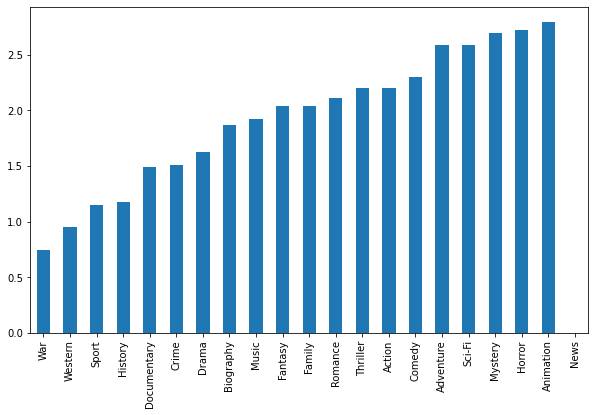

In [111]:
#plot a vertical bar graph
plt.figure(figsize=(10,6))
question_1b_m.plot.bar()
plt.show()

Why, so we see that Animation and Adventure still have top median ROIs. But now we see News is up here. What's going on here? Well, let's talk budget. Maybe we can find some answers there.

### Question 2: How much money should we spend?

Budget is always a BIG QUESTION. But how do we answer this? Well, maybe we can see if there's any relationship between budgets and ROI.

Let's see if we can group budget into different categories, and then make some judgements on ROI. So first, let's assemble the budgets with ROI and Gross_Margin

In [112]:
#slice a table of relevant financial data
moneydf = genre_and_budget.loc[:,'production_budget':'Gross_Margin']
moneydf['budget'] = moneydf['production_budget']
moneydf = moneydf.loc[:,'ROI':'budget']

#sort values in ascending order
moneydf.sort_values('ROI', ascending = False).head(30)

,ROI,Gross_Margin,budget
2826,416.56,41556474,100000
2758,101.76,100759490,1000000
1430,66.58,98370886,1500000
3501,64.36,63364198,1000000
2014,59.17,174512032,3000000
2465,55.79,273964806,5000000
1075,51.07,250367951,5000000
1833,43.50,63745512,1500000
546,42.41,41411721,1000000
2015,41.41,202039844,5000000


Wow! We see some high ROIs. Let's see that distribution of budget!

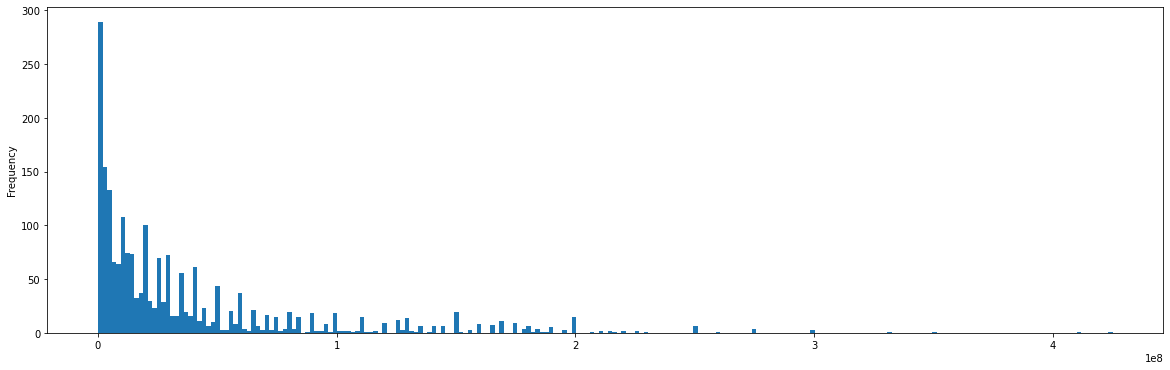

In [113]:
#let's plot a distribution (histogram) of all the movies made
plt.figure(figsize=(20,6))
moneydf['budget'].plot.hist(bins=225)
plt.show()

Whoa. A lot of small budget movies here. Let's see what the median budget is.


In [114]:
#let's find the the median and mean
print(moneydf['budget'].median())
print(moneydf['budget'].mean())

19500000.0
37652578.94383101


So the median budget is 19.5M, while the mean is ~38M. This shows a skew to the left, which makes sense considering the number of movies made for the cheap. Also, we can look at the graph above and see a sharp skew to the left.

Let's do a quick scatter plot of all movies of ROI vs budget. This may give us a general sense of which movies do the best.

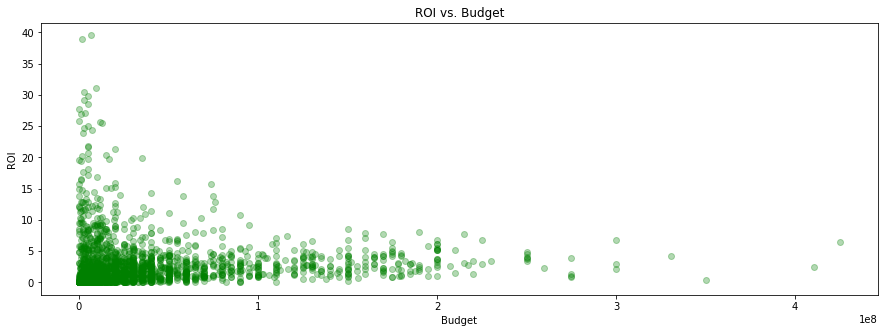

In [115]:
#let's limit the movies with ROIs under 40
moneydf = moneydf.loc[moneydf['ROI'] < 40]

#let's do a scatter plot with x-axis is budget and y value is ROI
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(moneydf['budget'],moneydf['ROI'],alpha=0.3, color="green")

#let's set some of the titles.
ax.set_title("ROI vs. Budget")
ax.set_xlabel("Budget")
ax.set_ylabel("ROI");


Wow, okay, there are many movies made on a small budget. It also looks like ROI doesn't increase with a higher budget. This makes sense intuitively, smaller budgets movie need to sell let's tickets in order to make their money back and show a return. 

Let's try to look more specifically at the budgets and see if we can find where we see the most success. Let's put the budgets into different categories. <1M, 1M < 15M, 15 - 30M, 30-45M, 45-150M, >1500M. And let's also get rid of the outlier ROIs that are astronomically high. We'll look at the total number of movies that make a positive return on investment.

In [116]:
#slice only the data without outliers
moneydf = moneydf.loc[(moneydf['ROI'] >= 1) & (moneydf['ROI'] < 20)]

#categorize are budgets into nice categories
Micro = moneydf.loc[moneydf['budget'] <= 1000000]
Small = moneydf.loc[(moneydf['budget'] > 1000000) & (moneydf['budget'] < 15000000)]
Mid = moneydf.loc[(moneydf['budget'] >= 15000000) & (moneydf['budget'] < 30000000)]
Large = moneydf.loc[(moneydf['budget'] >= 30000000) & (moneydf['budget'] < 450000000)]
Macro = moneydf.loc[(moneydf['budget'] >= 450000000) & (moneydf['budget'] < 150000000)]
Enormous = moneydf.loc[moneydf['budget'] >= 150000000]

Let's try and make a histrogram of all movies in the budget categories and what their ROI is.

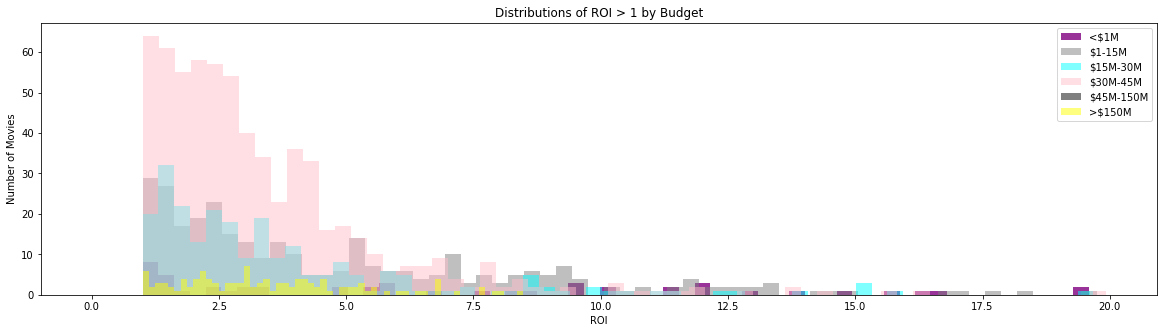

In [117]:
#create a histrogram plot
fig, ax = plt.subplots(figsize=(20,5))

# Create custom bins so all are on the same scale
bins = 60

# Plot three histograms, with reduced opacity (alpha) so we can see them overlapping
ax.hist(
    x=Micro["ROI"],
    label="<$1M",
    bins=bins,
    color="purple",
    alpha=0.8
)
ax.hist(
    x=Small["ROI"],
    label="$1-15M",
    bins=bins,
    color="gray",
    alpha=0.5
)
ax.hist(
    x=Mid["ROI"],
    label="$15M-30M",
    bins=bins,
    color="cyan",
    alpha=0.5
)

ax.hist(
    x=Large["ROI"],
    label="$30M-45M",
    bins=bins,
    color="pink",
    alpha=0.5
)

ax.hist(
    x=Macro["ROI"],
    label="$45M-150M",
    bins=bins,
    color="black",
    alpha=0.5
)

ax.hist(
    x=Enormous["ROI"],
    label=">$150M",
    bins=bins,
    color="yellow",
    alpha=0.5
)

# Customize labels
ax.set_title("Distributions of ROI > 1 by Budget")
ax.set_xlabel("ROI")
ax.set_ylabel("Number of Movies")
ax.legend();

### Visualization 2: Distribution of Movies with High ROIs

Aha! We can see here that many movies in the $30-45M budget range that have done well! That's a good starting point.

### Recommendation 2: Make movies in the $30-45M range. These budgets produce the most movies with positive ROIs.

But who's going to make this movie in the $30M-45M range? The last piece of the puzzle is the director. So let's find them!  

### Question 3: The Director

So... we did a nice job in the early phases of getting some of that director information into our dataframe. And, we already know what our budget is. So why don't we find a list of directors who make movies in these budges and see which have the best ROIs

To start, let's make a table of the director information

In [118]:
#slice a new dataframe based on director info
directordf = genre_and_budget.loc[:,'production_budget':'Gross_Margin']
directordf['budget'] = directordf['production_budget'] 
directordf = directordf.loc[:,'primary_name':'budget']

#do a count of all of the directors here
directordf['primary_name'].value_counts()

Steven Spielberg       7
Jon M. Chu             6
Steven Soderbergh      6
Clint Eastwood         6
David Gordon Green     6
                      ..
Lisa Azuelos           1
Jay Coster             1
Douglas Aarniokoski    1
Mike Mills             1
Fred Andrews           1
Name: primary_name, Length: 1581, dtype: int64

Okay. We've got some familiary names here. Now let's find the best directors for our budget range ($30-45M). Maybe... some directors who have made more than 1 movie in this budget range.

In [119]:
#slice the movies from our director dataframe with $30-45M budget range
midbudgetdirector = directordf.loc[(directordf['budget'] >= 30000000) & (directordf['budget'] <= 45000000)]

#Now, let's slice a new dataframe and count the totals by name
midbudgetdirector2 = midbudgetdirector.groupby('primary_name').count()

#Now, let's slice this dataframe and keep only the directors where the count is greater than 1
midbudgetdirector2 = midbudgetdirector2.loc[midbudgetdirector2['budget'] > 1]
midbudgetdirector2 = midbudgetdirector2.reset_index()

#Now, let's make a list of these directors and print it out.
directorlist = list(midbudgetdirector2['primary_name'])
directorlist

['Anne Fletcher',
 'Ben Affleck',
 'Bobby Farrelly',
 'Brad Furman',
 'Charles Martin Smith',
 'Clint Eastwood',
 'David Frankel',
 'David Leitch',
 'Drew Goddard',
 'Etan Cohen',
 'Frank Coraci',
 'J.A. Bayona',
 'Jaume Collet-Serra',
 'Joe Wright',
 'John Francis Daley',
 'Jon M. Chu',
 'Jonathan Levine',
 'Nicholas Stoller',
 'Olivier Megaton',
 'Paul Feig',
 'Peter Berg',
 'Rob Cohen',
 'Robert Zemeckis',
 'Roland Joffé',
 'S.S. Rajamouli',
 'Seth Gordon',
 'Simon West']

Now that we have this list, let's make a list of the average (mean) `Gross-Margin` for these directors. I'm picking `Gross_Margin` because now that we know our budget range, we want to know who's making the most money. ROI might give us different insight about someone who spent 30M and someone who spent 45M, when really those budgets are in the SAME category. So let's do it.

To do this, we're going to slice a new datafram containing the `Gross_Margin` of only the directors from our list AND only the movies that they directed from our budget range. Once we have this list we can find the mean of the `Gross_Margin`.

In [120]:
#make a function to determine if the director is on our list
def middirector (director):
    for directors in directorlist:
        if (directors == director):
            return True

#slice new dataframe that checks our director's name and budget of movie
midbudgetdirectors = directordf.loc[directordf['primary_name'].map(middirector) & (directordf['budget'] >= 30000000) & (directordf['budget'] <= 45000000)]

#create list of midbudget directors grouped by 'primary_name' and sorted by the mean of 'Gross_Margin'
prime_directors = midbudgetdirectors.groupby('primary_name')['Gross_Margin'].mean().sort_values(ascending=True)
prime_directors


primary_name
Roland Joffé           -3.346256e+07
Rob Cohen              -4.304778e+06
Simon West             -2.956357e+06
Anne Fletcher           5.983093e+06
Drew Goddard            1.894717e+07
Etan Cohen              3.321903e+07
Clint Eastwood          3.366165e+07
Brad Furman             3.882888e+07
David Frankel           3.969297e+07
Charles Martin Smith    4.044663e+07
Jonathan Levine         4.441632e+07
Robert Zemeckis         4.871668e+07
Peter Berg              5.131258e+07
Nicholas Stoller        5.227910e+07
Frank Coraci            5.711500e+07
David Leitch            5.729021e+07
J.A. Bayona             6.650257e+07
Bobby Farrelly          7.030292e+07
John Francis Daley      7.584229e+07
Joe Wright              7.807543e+07
Jaume Collet-Serra      7.905426e+07
S.S. Rajamouli          1.101198e+08
Ben Affleck             1.491038e+08
Seth Gordon             1.588896e+08
Jon M. Chu              1.719944e+08
Olivier Megaton         1.825513e+08
Paul Feig               2

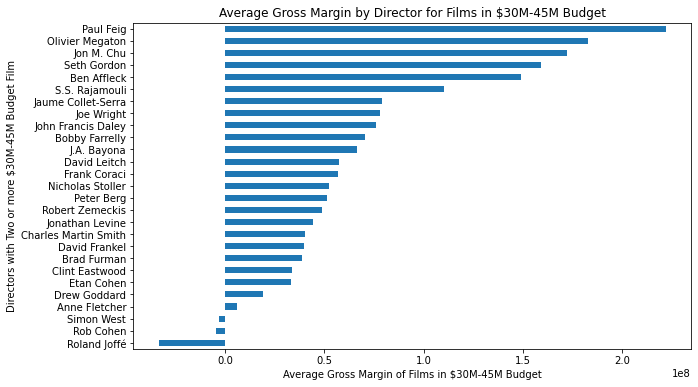

In [121]:
plt.figure(figsize=(10,6))
prime_directors.plot.barh()

plt.title('Average Gross Margin by Director for Films in $30M-45M Budget')
plt.ylabel('Directors with Two or more $30M-45M Budget Film')
plt.xlabel('Average Gross Margin of Films in $30M-45M Budget')
plt.show()


### Visualization 3: Directors with Largest Average Margins for MidBudget Films

### Recommendation 3: Hire a Director with Track Record for Profitable Films in your budget range

The visual above shows many directors who have a proven track record in this budget range. Let's give some of the names at the top of the list a call and see what they're working on!